In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
import os
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
figpath = '/home/lengyel/lengyelgaborwork@gmail.com/Gabor/P6_Farran_noiseR/Figs'

In [2]:
class GenCorSpkTrain:
    
    """generating correlated spike trains"""
    
    def __init__(self, exp_parameters, trial_parameter, model_parameters):

        self.nBlocks = np.vstack((np.random.randint(exp_parameters[1],exp_parameters[2],exp_parameters[0]),np.random.randint(exp_parameters[3],exp_parameters[4],exp_parameters[0]))) # first row is the size of a block ; the second row is the number of repetition of the blocks; Ntrials = first_row*second_row
        self.Nsession = exp_parameters[0]-1
        self.TrialStruct = trial_parameter
        self.PopParam = model_parameters
    
    def generate_spikes(self, saving=True):
        
        self.maximum_time = sum([sum(self.TrialStruct[0:3]), self.TrialStruct[3][1], self.TrialStruct[4], self.TrialStruct[5][1]])
        self.maximum_rate = int((self.PopParam[2][0] + self.PopParam[4][0] + 10) * self.maximum_time)
        
        base_rate = np.random.normal(self.PopParam[2][0], self.PopParam[2][1], self.PopParam[1])
        cue_rate = base_rate + np.random.normal(self.PopParam[3][0], self.PopParam[3][1], self.PopParam[1])
        stim_rate = base_rate + np.random.normal(self.PopParam[4][0], self.PopParam[4][1], self.PopParam[1])
        self.PSTH = np.vstack((base_rate, cue_rate, stim_rate)) # generating the firing rates for the trials for each unit
        self.PSTH[self.PSTH<0] = 0.000001
        self.sig_for_PSTH = st.norm.ppf(self.PopParam[0]*self.PSTH)
        mean = np.zeros(self.PopParam[1])
        self.diag_ix = np.diag_indices(self.PopParam[1])
        il = np.tril_indices(self.PopParam[1])
        self.spikes = {}
        self.trials = {}
        
        for ses,block in enumerate(self.nBlocks.T):
            
            spk = np.zeros(self.PopParam[1])
            trls = np.zeros(7)
            
            for blk in range(block[1]):
                
                if blk%2==0:
                    cov = np.random.normal(self.PopParam[5]+0.05,self.PopParam[6],(self.PopParam[1],self.PopParam[1]))
                    cov[il] = cov.T[il]
                    cov[self.diag_ix] = 1.0
                else:
                    cov = np.random.normal(self.PopParam[5],self.PopParam[6],(self.PopParam[1],self.PopParam[1]))
                    cov[il] = cov.T[il]
                    cov[self.diag_ix] = 1.0

                for trial in range(block[0]):

                    stim_dur = (self.TrialStruct[2]+((self.TrialStruct[3][1] - self.TrialStruct[3][0]) * np.random.random_sample() + self.TrialStruct[3][0]))/self.PopParam[0]
                    iti_dur = ((self.TrialStruct[5][1] - self.TrialStruct[5][0]) * np.random.random_sample() + self.TrialStruct[5][0])/self.PopParam[0]
                    
                    trial_dur = [int(self.TrialStruct[0]/self.PopParam[0]), int(self.TrialStruct[1]/self.PopParam[0]), int(stim_dur), int(self.TrialStruct[4]/self.PopParam[0]), int(iti_dur)]
                    
                    spikes_fix = ((self.sig_for_PSTH[0,:] + np.random.multivariate_normal(mean,cov,trial_dur[0]))>0)
                    spikes_cue = ((self.sig_for_PSTH[1,:] + np.random.multivariate_normal(mean,cov,trial_dur[1]))>0)
                    spikes_stim = ((self.sig_for_PSTH[2,:] + np.random.multivariate_normal(mean,cov,trial_dur[2]))>0)
                    spikes_resp = ((self.sig_for_PSTH[2,:] + np.random.multivariate_normal(mean,cov,trial_dur[3]))>0)
                    spikes_iti = ((self.sig_for_PSTH[0,:] + np.random.multivariate_normal(mean,cov,trial_dur[4]))>0)
                    spk_in_trial = np.vstack((spikes_fix,spikes_cue,spikes_stim,spikes_resp,spikes_iti))
                    spk = np.vstack((spk,spk_in_trial))
                    
                    length_of_trial = spk_in_trial.shape[0]
                    trial_event_times = np.zeros((4,length_of_trial))
                    trial_event_times[0,0] = 1 # fixation starts
                    trial_event_times[1,trial_dur[0]] = 1 # cue starts
                    trial_event_times[2,trial_dur[0]+trial_dur[1]] = 1 # stim starts
                    trial_event_times[3,trial_dur[0]+trial_dur[1]+trial_dur[2]+trial_dur[3]] = 1 # stim ends
                    trls_in_trial = np.vstack((np.repeat(blk,length_of_trial),np.repeat(trial+1,length_of_trial),np.repeat(trial+blk*block[0],length_of_trial),trial_event_times[0,:],trial_event_times[1,:],trial_event_times[2,:],trial_event_times[3,:])).T
                    trls = np.vstack((trls,trls_in_trial))
                    
            self.spikes['session'+str(ses)] = spk[1:,:]
            self.trials['session'+str(ses)] = trls[1:,:]
            self.covariance = cov
            
        if saving: 
            np.save('spks', self.spikes)
        
        
    def plot_spikes(self, N = (2,2,2), saving = ''):
        
        self.convert_save_spikes(data_type='mat', saving_folder = saving)  
        axisFont={'fontname':'Arial', 'size':'24'}
        sessions = np.random.choice(self.Nsession,N[0],replace=False)

        fig,ax = plt.subplots(N[0]*N[1]*N[2],1, figsize = (30,(N[0]+N[1]+N[2])*12))
        ax = ax.ravel()
        i=0
        
        for ses in sessions:
            
            nblock = self.nBlocks[1][ses]
            ntrial = self.nBlocks[0][ses]
            blocks = np.random.choice(nblock,N[1],replace=False)
            trials = np.random.choice(ntrial-1,N[2],replace=False)
            ses_name = str(ses)

            for blk in blocks:
                for t,trl in enumerate(trials):
                    
                    trial = trl + blk*ntrial
                    trl_d = self.trial_times['session'+ses_name][trial]
                    spk_d = self.spike_times['session'+ses_name]
                    trial_bound = [trl_d[0], self.trial_times['session'+ses_name][trial+1][0]]
                    spk_ix = np.where((spk_d > trial_bound[0]) & (spk_d < trial_bound[1]))
                    spikes_in_trial = np.zeros((self.PopParam[1], self.maximum_rate))
                    
                    for ui,u in enumerate(np.unique(spk_ix[1])):
                        spk_time = spk_d[spk_ix[0][spk_ix[1]==u],u]
                        spikes_in_trial[ui,:len(spk_time)] = spk_time
                        
                    spikes_in_trial[spikes_in_trial==0] = trl_d[0]
                    spikes_in_trial = spikes_in_trial-trl_d[0]
                    ax[i].eventplot(spikes_in_trial,linelengths = 0.4, colors =  [[0, 0, 0]])
                    
                    for ev in trl_d[:-1]:
                        ax[i].plot([ev-trl_d[0],ev-trl_d[0]],[0,self.PopParam[1]],'r-')
                        
                    if i==N[0]*N[1]*N[2]+1:
                        ax[i].set_xlabel('time(ms)',**axisFont)
                    else:
                        ax[i].set_xlabel(' ',**axisFont)
                    ax[i].set_ylabel('unit #',**axisFont)
                    ax[i].set_title('session_'+ses_name+' block_'+str(blk)+' trial_'+str(trl),**axisFont)
                    ax[i].spines['top'].set_visible(False)
                    ax[i].xaxis.set_ticks_position('bottom')
                    ax[i].spines['right'].set_visible(False)
                    ax[i].yaxis.set_ticks_position('left')
                    i=i+1               

        plt.tight_layout(pad=1, w_pad=1, h_pad=1)
        if len(saving)>2:
            plt.savefig(saving+'/raster_plot.pdf')
        plt.show()
    
    
    def plot_PSTH(self, N = 4, saving = ''):
        
        axisFont={'fontname':'Arial', 'size':'24'}
        sessions = np.random.choice(self.Nsession,N,replace=False)

        fig,ax = plt.subplots(N,1, figsize = (30,N*12))
        ax = ax.ravel()
        winS = 20
        i=0
        
        for ses in sessions:
            
            nblock = self.nBlocks[1][ses]
            ntrial = self.nBlocks[0][ses]
            ses_name = str(ses)
            alltrial = nblock*ntrial
            PSTH = np.zeros((alltrial,1+int(self.maximum_time/self.PopParam[0]),self.PopParam[1]))
            ix0 = 0
            
            for t in range(alltrial):
                
                ix = self.trials['session'+ses_name][:,2]==t
                nbin = sum(ix)
                PSTH[t,ix0:nbin,:] = self.spikes['session'+ses_name][ix,:]
                ixo = nbin
                   
            average_unit = np.mean(np.mean(PSTH, axis=2), axis=0)
            cumsum = np.cumsum(average_unit) 
            move_mean = (cumsum[winS:] - cumsum[:-winS]) / float(winS)
            ax[i].plot(average_unit/self.PopParam[0], 'k-', linewidth=2)
            ax[i].plot(move_mean/self.PopParam[0], 'r-', linewidth=2)
            evr =0
            
            for ev in np.hstack((self.TrialStruct[:3], self.TrialStruct[3][0], self.TrialStruct[3][1], self.TrialStruct[4], self.TrialStruct[5][0], self.TrialStruct[5][1])):
                evr = evr+ev
                ax[i].plot([evr/self.PopParam[0],evr/self.PopParam[0]],[0,2*self.maximum_rate/self.maximum_time],'r-')

            ax[i].set_xlabel(' ',**axisFont)
            ax[i].set_ylabel('firing rate (hz)',**axisFont)
            ax[i].set_title('PSTH for session_'+ses_name,**axisFont)
            ax[i].spines['top'].set_visible(False)
            ax[i].xaxis.set_ticks_position('bottom')
            ax[i].spines['right'].set_visible(False)
            ax[i].yaxis.set_ticks_position('left')
            i=i+1
            
        plt.tight_layout(pad=1, w_pad=1, h_pad=1)
        if len(saving)>2:
            plt.savefig(saving+'/PSTH_plot.pdf')
        plt.show()
        
    
    def plot_noise_corr(self, saving = ''):
        
        N=2
        sessions = np.random.choice(self.Nsession,N,replace=False)
        axisFont={'fontname':'Arial', 'size':'24'}
        fig,ax = plt.subplots(N+1,1, figsize = (8,N*8))
        ax = ax.ravel()
        
        for i in range(N+1):
            
            if i==N:
                r_noise = self.covariance
            else:
                ses = sessions[i]
                nblock = self.nBlocks[1][ses]
                ntrial = self.nBlocks[0][ses]
                ses_name = str(ses)
                alltrial = nblock*ntrial

                r0 = np.mean(self.spikes['session'+ses_name], axis=0)
                var0 = r0*(1-r0)
                out_r0 = np.outer(r0,r0)
                out_var0 = np.outer(var0,var0)
                cdfs = S.PopParam[0]*S.PSTH
                cov_t = np.ones((self.PopParam[1],self.PopParam[1],3))
                cov_s = np.zeros((self.PopParam[1],self.PopParam[1],3))
                for r in range(cdfs.shape[0]):
                    cov_s[:,:,r] = np.outer(cdfs[r,:],cdfs[r,:])

                    for ui in range(self.PopParam[1]):
                        S_p = self.sig_for_PSTH[r,ui]
                        for uj in range(self.PopParam[1]):
                            if ui!=uj:
                                S_q = self.sig_for_PSTH[r,uj]
                                r_p = self.covariance[ui,uj]
                                cov_t[ui,uj,r] = st.multivariate_normal.cdf([S_p,S_q], mean=[0,0], cov=np.array([[1,r_p],[r_p,1]]))

                cov_s = np.mean(cov_s,axis=2)-out_r0
                cov_t = np.mean(cov_t,axis=2)-out_r0
                r_noise = ((cov_t)/(np.sqrt(out_var0)))-((cov_s)/(np.sqrt(out_var0)))
                r_noise[self.diag_ix] = 0
            
            im = ax[i].imshow(r_noise)
            fig.colorbar(im,ax=ax[i])
            ax[i].set_xlabel('unit i#',**axisFont)
            ax[i].set_ylabel('unit j#',**axisFont)
            if i==N:
                ax[i].set_title('Covariance matrix',**axisFont)
            else:
                ax[i].set_title('Noise correlation_'+ses_name,**axisFont)
            ax[i].spines['top'].set_visible(False)
            ax[i].xaxis.set_ticks_position('bottom')
            ax[i].spines['right'].set_visible(False)
            ax[i].yaxis.set_ticks_position('left')
            i=i+1
            
        plt.tight_layout(pad=1, w_pad=1, h_pad=1)
        if len(saving)>2:
            plt.savefig(saving+'/cov_plot.pdf')
        plt.show()
        
        self.r_noise = r_noise
        
    
    def convert_save_spikes(self, data_type='mat', saving_folder = ''):
        
        self.spike_times = {}
        self.trial_times = {}
        
        for s in self.spikes.keys():
            ses_name = str(s)         
            trl_i = np.nonzero(self.trials[ses_name][:,3:])
            spk_i = np.nonzero(self.spikes[ses_name])    
            trial_event_type = np.unique(trl_i[1])
            units = np.unique(spk_i[1]) 
            
            if data_type=='list':
                spk_t = [spk_i[0][spk_i[1]==i] for i in units]  
                trl_t = [trl_i[0][trl_i[1]==i] for i in trial_event_type]
            elif data_type=='mat':
                ses_num = int(s[-1]) if s[-2]=='n' else int(s[-2:])
                ntrials = self.nBlocks[0][ses_num]*self.nBlocks[1][ses_num]
                maximum = self.maximum_rate*ntrials
                trl_t = np.zeros((ntrials,len(trial_event_type)+1))
                spk_t = np.zeros((maximum,len(units)))
                for ti,t in enumerate(trial_event_type):
                    trl_event = trl_i[0][trl_i[1]==t]
                    trl_t[:len(trl_event),ti] = trl_event
                    if ti==0:
                        trl_t[:len(trl_event),-1] = self.trials[ses_name][trl_event,0]
                for ui,u in enumerate(units):
                    spk_event = spk_i[0][spk_i[1]==u]
                    spk_t[:len(spk_event),ui] = spk_event
            
            self.trial_times[ses_name] = trl_t
            self.spike_times[ses_name] = spk_t
            
            if len(saving_folder)>2:
                np.savetxt(saving_folder+'/spike/'+ses_name+'_spike_times.csv', spk_t, delimiter=',')
                np.savetxt(saving_folder+'/trial/'+ses_name+'_trial_times.csv', trl_t, delimiter=',')

In [9]:
Nsession = 12
min_block_size = 5
max_block_size = 20
min_rep_block = 2
max_rep_block = 6

exp_parameters = (Nsession, min_block_size, max_block_size, min_rep_block, max_rep_block)

fix = 0.05
cue = 0.3
stim = 1.0
change = (1.0,3.0)
resp = 0.5
ITI = (1.0,2.0)

trial_parameters = (fix, cue, stim, change, resp, ITI)

dt = 1.0/1000
nunit = 24
base_pop_fire = (10,1)
cue_pop_fire = (20,1)
stim_pop_fire = (30,3)
pop_noise_r = 0.35
pop_noise_r_var = 0.01 

model_parameters = (dt, nunit, base_pop_fire, cue_pop_fire, stim_pop_fire, pop_noise_r, pop_noise_r_var)

In [10]:
S=GenCorSpkTrain(exp_parameters, trial_parameters, model_parameters)

In [11]:
S.generate_spikes()

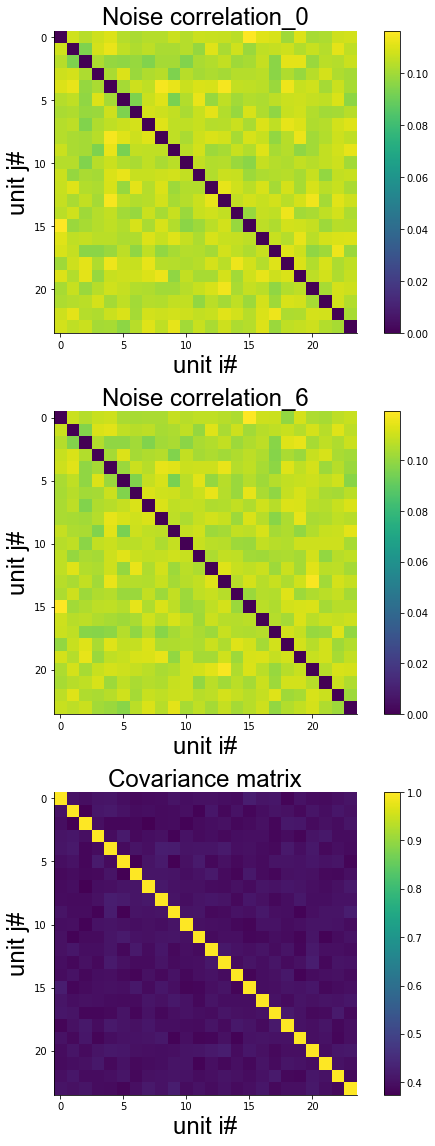

In [12]:
S.plot_noise_corr(saving = '/home/lengyel/lengyelgaborwork@gmail.com/Gabor/P6_Farran_noiseR/data/synthetic')

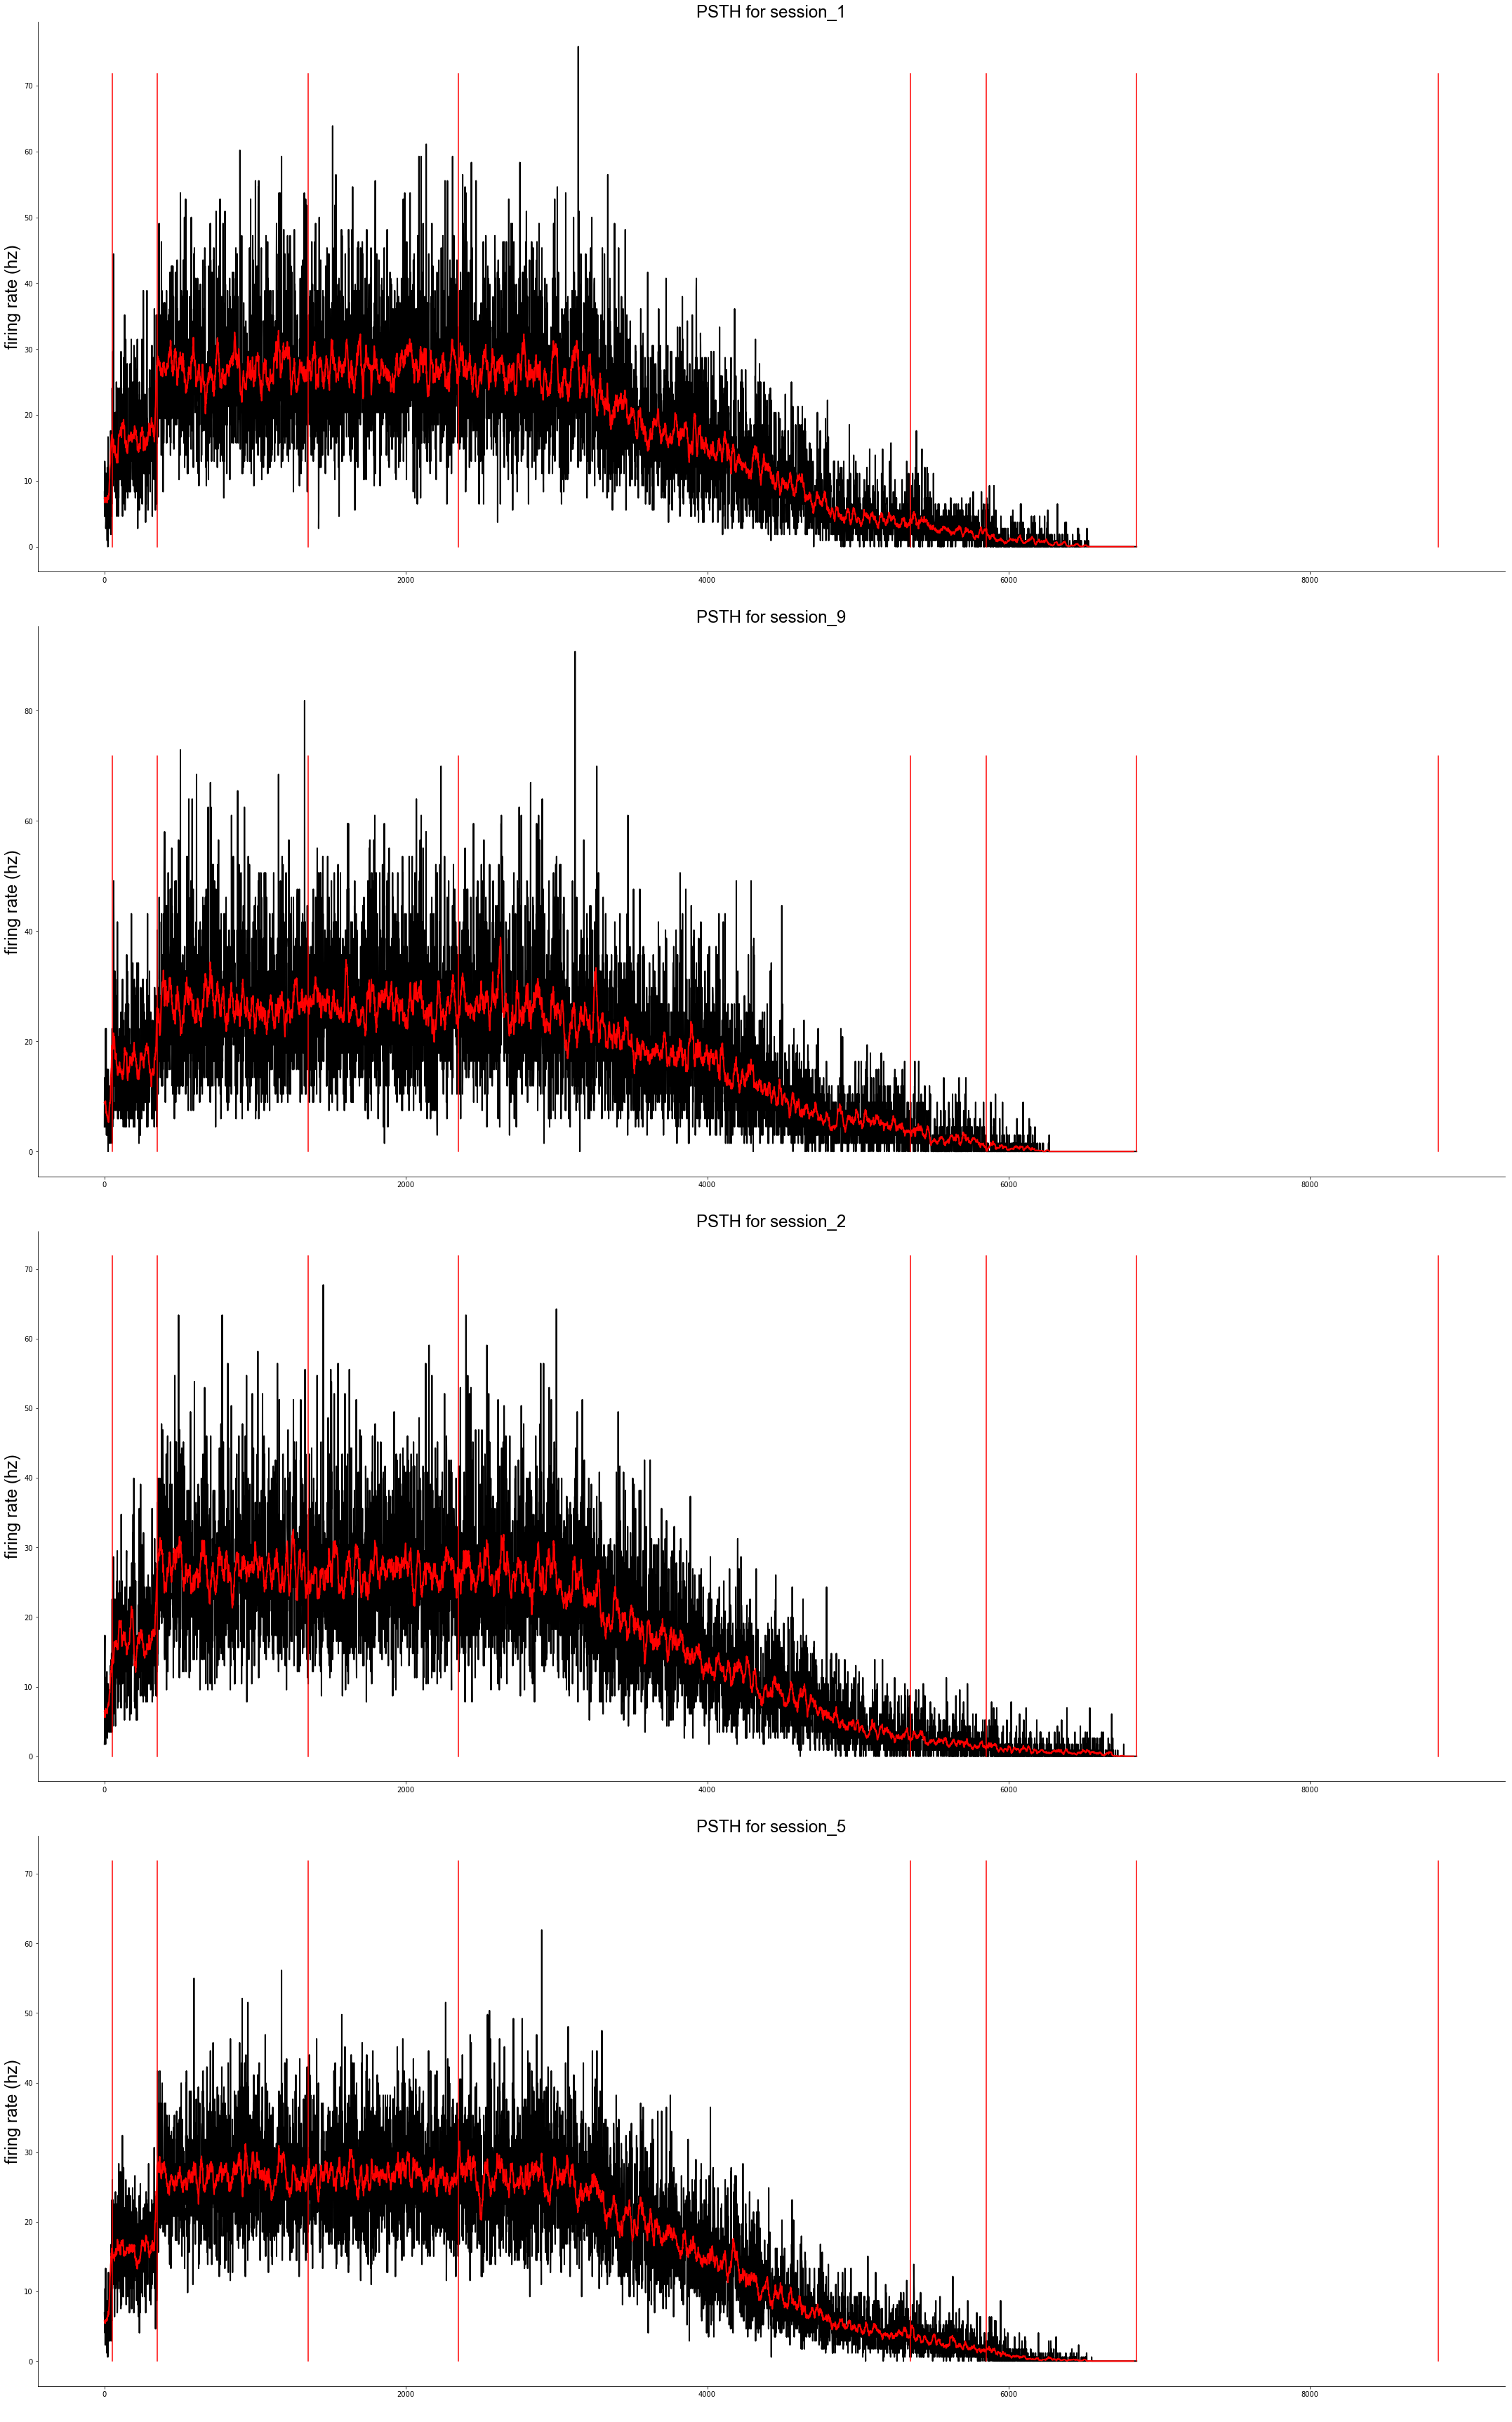

In [7]:
S.plot_PSTH(saving = '/home/lengyel/lengyelgaborwork@gmail.com/Gabor/P6_Farran_noiseR/data/synthetic')

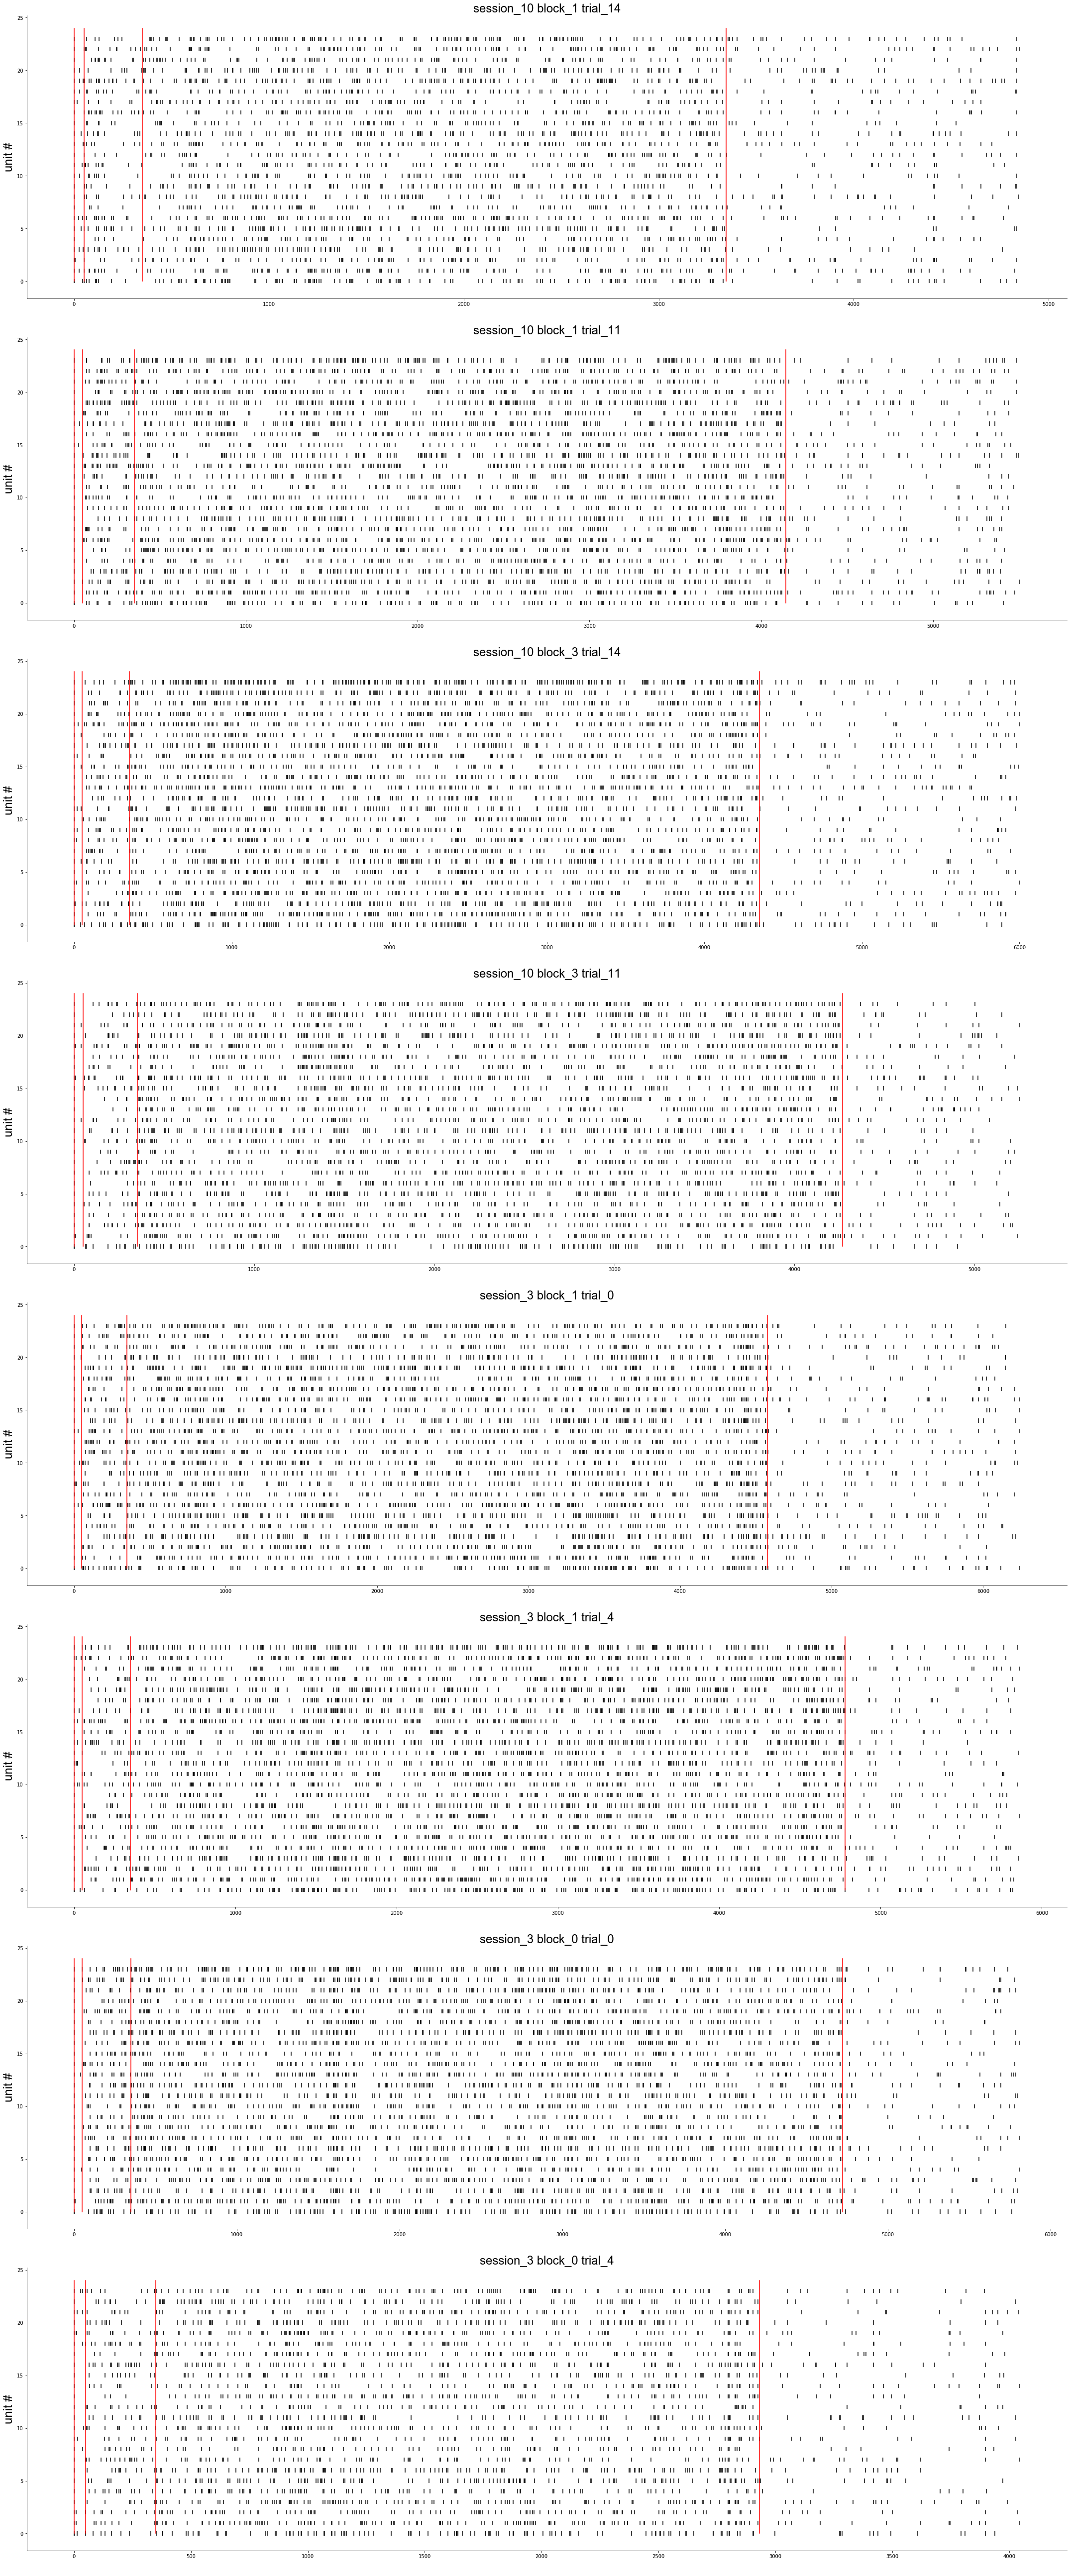

In [14]:
S.plot_spikes(saving = '/home/lengyel/lengyelgaborwork@gmail.com/Gabor/P6_Farran_noiseR/data/synthetic')